In [1]:
from tensorflow import keras
from keras import preprocessing
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
#Loading the data
Dataset= os.listdir('data')

#checking the data type
data_type= os.listdir('data')
print(data_type)  #What kind of data/classses are in dataset


print('types of class found= ', len(data_type))

['Test', 'Train']
types of class found=  2


In [3]:
#Calling all the folders/images in a signle list or single place
covid= []

for i in data_type:
    #get all the file names
    All_dat= os.listdir('data' + "/" +i)
    #print(All_dat)

#Adding to a single folder/empty list
    for j in All_dat:
        covid.append((i,str('data' + "/" +i) + '/' + j))
        #print(covid[:2])

covid

[('Test', 'data/Test/Lungs'),
 ('Test', 'data/Test/Others'),
 ('Train', 'data/Train/Lungs'),
 ('Train', 'data/Train/Others')]

In [4]:
#Building a dataframe and assing folder name and images in seperate column
covid_df= pd.DataFrame(data= covid, columns= ['class Type', 'Images'])
#covid_df.head()
print(covid_df.tail())

  class Type             Images
0       Test    data/Test/Lungs
1       Test   data/Test/Others
2      Train   data/Train/Lungs
3      Train  data/Train/Others


In [5]:
#Checking the how many datasets are present in which folder
print('Total number of images= ', len(covid_df))

#Classwise counting 
data_count= covid_df['class Type'].value_counts()
print("Number of data in each class:=", data_count)

Total number of images=  4
Number of data in each class:= Train    2
Test     2
Name: class Type, dtype: int64


In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet101
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [3]:

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'Data/train'
valid_path = 'Data/test'

In [4]:
# Importing Resnet50 library as shown below and add preprocessing layer to the front of Resnet50
# Here we will be using imagenet weights

resnet = ResNet101(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [5]:
resnet.summary()

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

conv4_block22_1_bn (BatchNormal (None, 14, 14, 256)  1024        conv4_block22_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block22_1_relu (Activatio (None, 14, 14, 256)  0           conv4_block22_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_block22_2_conv (Conv2D)   (None, 14, 14, 256)  590080      conv4_block22_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block22_2_bn (BatchNormal (None, 14, 14, 256)  1024        conv4_block22_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block22_2_relu (Activatio (None, 14, 14, 256)  0           conv4_block22_2_bn[0][0]         
__________________________________________________________________________________________________
conv4_bloc

In [6]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False
    

In [7]:
# useful for getting number of output classes
folders = glob('Data/train/*')

In [8]:
folders

['Data/train\\Lungs', 'Data/train\\Others']

In [9]:
# our layers - you can add more if you want
x = Flatten()(resnet.output)

In [10]:
len(folders)

2

In [11]:
prediction = Dense(len(folders), activation='softmax', name= "FC")(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [13]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [19]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

#In test data we don't do data augumentation

test_datagen = ImageDataGenerator(rescale = 1./255)

In [20]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('Data/train',
                                                 target_size = (224, 224),
                                                 batch_size = 500,
                                                 class_mode = 'categorical')   #class_mode = 'categorical' when we have more then
                                                                            # 2 classes

Found 27136 images belonging to 2 classes.


In [21]:
test_set = test_datagen.flow_from_directory('Data/test',
                                            target_size = (224, 224),
                                            batch_size = 500,
                                            class_mode = 'categorical')

Found 2029 images belonging to 2 classes.


In [22]:
len(test_set), len(training_set)

(5, 55)

In [ ]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=200,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

c:\users\ram shankar\anaconda3\envs\medical_imaging\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200


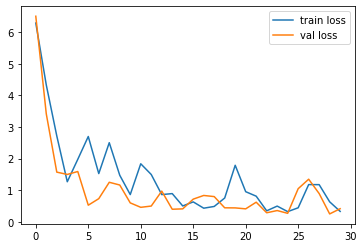

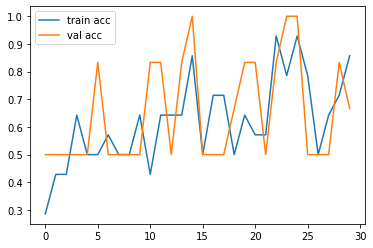

<Figure size 432x288 with 0 Axes>

In [52]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [54]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_resnet101.h5')

c:\users\ram shankar\anaconda3\envs\medical_imaging\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [55]:
y_pred = model.predict(test_set)

In [56]:
y_pred

array([[0.02443175, 0.97556823],
       [0.62535733, 0.3746427 ],
       [0.414383  , 0.58561695],
       [0.39181793, 0.6081821 ],
       [0.00856232, 0.99143773],
       [0.15086843, 0.8491316 ]], dtype=float32)

# Testing model on unseen data 

In [78]:
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
img_path= 'Data\Test\covid\COVID-1002.png'
img= image.load_img(img_path, target_size=(224,224))
x= image.img_to_array(img)
x= np.expand_dims(x, axis=0)
x= preprocess_input(x)
print("input image shape", x.shape)
my_image= imread(img_path)
#plt.imshow(my_image)
print(model.predict(x))

input image shape (1, 224, 224, 3)
[[5.0491712e-06 9.9999499e-01]]


In [79]:
a=np.argmax(model.predict(x), axis=1)

In [80]:
if a==1:
    print('Covid')
else:
    print('Normal')

Covid


In [ ]:
training_set.class_indices
if result[0][0] == 0:
    prediction = 'covid'
    print(prediction)
else:
    prediction = 'Normal'
    print(prediction)